# Neural Network Model for Q274 Prediction with Hyperparameter Tuning

This notebook implements a neural network with gradient descent, comprehensive hyperparameter tuning, and LLM-based analysis to predict Q274 (number of children) from the preprocessed World Values Survey data.

1. **Hyperparameter Tuning**: Systematic search across 135 configurations testing different:
   - Network architectures (5 options)
   - Dropout rates (3 options)
   - Learning rates (3 options)
   - Batch sizes (3 options)

2. **Cross-Validation**: 5-fold CV for robust hyperparameter selection

3. **Gradient Descent Optimization**: Adam optimizer with:
   - Adaptive learning rates
   - Momentum-based updates
   - L2 regularization

4. **LLM-Powered Analysis**: Automated expert-level interpretation of results

5. **Comprehensive Evaluation**: Multiple metrics, visualizations, and sensitivity analyses

### Key Features:
- **Reproducible**: Fixed random seeds for consistent results
- **Efficient**: Early stopping and learning rate scheduling
- **Interpretable**: Extensive visualizations and metrics
- **Automated**: LLM agent for intelligent analysis

## 1. Import Libraries

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# For neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# LLM client (optional)
os.environ["OPENAI_API_KEY"] = "sk-"  # Replace with your API key
try:
    from openai import OpenAI
    client = OpenAI()
    print("✓ OpenAI client initialized")
except Exception as e:
    client = None
    print(f"⚠️ OpenAI client not initialized: {e}")
    print("   LLM analysis will be skipped.")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ OpenAI client initialized
✓ Libraries imported successfully
PyTorch version: 2.6.0+cpu
CUDA available: False


## 2. Load and Prepare Data

In [2]:
# Load the preprocessed data
df = pd.read_csv('preprocessed_data.csv')

print(f"Original data shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")

# Check for Q274 column
target_col = 'Q274: How many children do you have'
if target_col not in df.columns:
    print(f"\n⚠️ Warning: Target column '{target_col}' not found in data")
    print("Available columns containing 'Q274':")
    print([col for col in df.columns if 'Q274' in col or 'children' in col.lower()])
else:
    print(f"\n✓ Target column '{target_col}' found")

Original data shape: (2012, 287)

Columns: 287

✓ Target column 'Q274: How many children do you have' found


In [3]:
# Remove rows where target is null
df_clean = df[df[target_col].notna()].copy()

print(f"Data shape after removing null targets: {df_clean.shape}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Separate features and target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget variable statistics:")
print(y.describe())

Data shape after removing null targets: (2012, 287)
Rows removed: 0

Feature matrix shape: (2012, 286)
Target vector shape: (2012,)

Target variable statistics:
count    2012.000000
mean        1.346421
std         1.346773
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: Q274: How many children do you have, dtype: float64


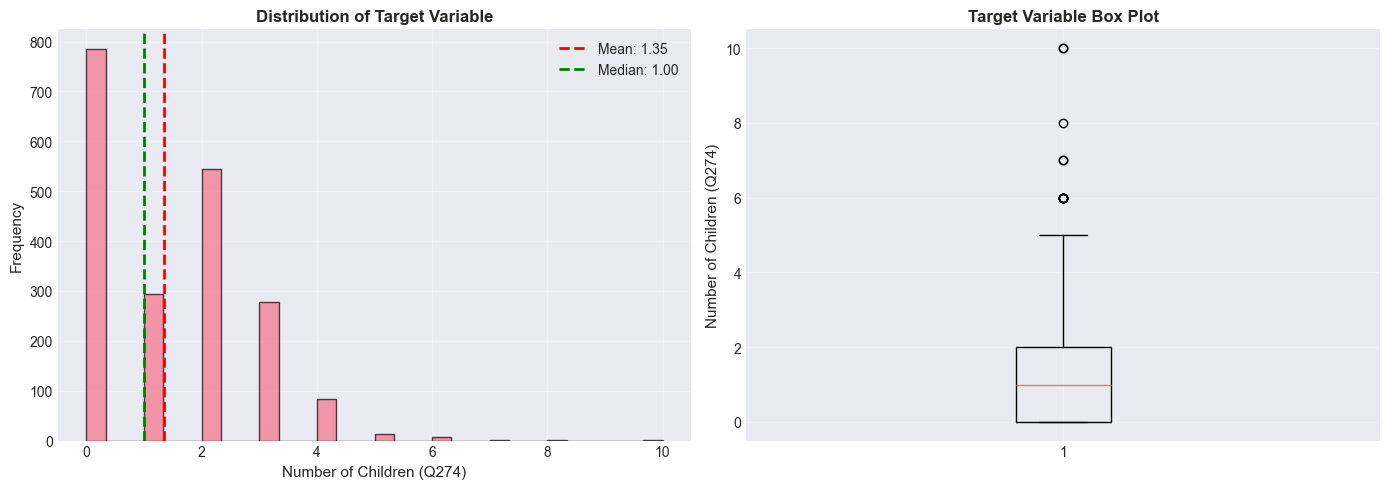


Skewness: 0.905
Kurtosis: 1.576


In [4]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Children (Q274)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Target Variable', fontsize=12, fontweight='bold')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[0].axvline(y.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {y.median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('Number of Children (Q274)', fontsize=11)
axes[1].set_title('Target Variable Box Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSkewness: {y.skew():.3f}")
print(f"Kurtosis: {y.kurtosis():.3f}")

## 3. Train-Test Split and Feature Scaling

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features standardized (mean=0, std=1)")
print(f"Training data mean: {X_train_scaled.mean():.6f}")
print(f"Training data std: {X_train_scaled.std():.6f}")

Training set size: 1609 samples
Testing set size: 403 samples
Number of features: 286

✓ Features standardized (mean=0, std=1)
Training data mean: 0.000000
Training data std: 1.000000


## 4. Define Neural Network Architecture

In [6]:
class NeuralNetworkRegressor(nn.Module):
    """
    Neural Network for regression with configurable architecture.
    
    Architecture:
    - Input layer: number of features
    - Hidden layers: fully connected with ReLU activation and dropout
    - Output layer: single neuron for regression
    """
    
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3):
        super(NeuralNetworkRegressor, self).__init__()
        
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

print("✓ Neural Network class defined")

✓ Neural Network class defined


## 5. Training Function with Cross-Validation

In [7]:
def train_and_evaluate(X_train_scaled, y_train, X_val_scaled, y_val, 
                       hidden_dims, dropout_rate, learning_rate, batch_size, 
                       num_epochs=100, verbose=False):
    """
    Train and evaluate a neural network with given hyperparameters.
    
    Returns:
        dict: Dictionary containing training metrics and best model
    """
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    input_dim = X_train_scaled.shape[1]
    model = NeuralNetworkRegressor(input_dim, hidden_dims, dropout_rate)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=5, verbose=False)
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 15
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor).item()
            val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stopping_patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor).numpy().flatten()
    
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'epochs_trained': len(train_losses)
    }

print("✓ Training function defined")

✓ Training function defined


## 6. Hyperparameter Tuning Grid

In [8]:
# Define hyperparameter grid
hyperparameter_grid = {
    'hidden_dims': [
        [128, 64, 32],
        [256, 128, 64],
        [256, 128, 64, 32],
        [512, 256, 128],
        [128, 64]
    ],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64]
}

# Calculate total combinations
total_combinations = (len(hyperparameter_grid['hidden_dims']) * 
                     len(hyperparameter_grid['dropout_rate']) * 
                     len(hyperparameter_grid['learning_rate']) * 
                     len(hyperparameter_grid['batch_size']))

print("Hyperparameter Grid:")
print("="*60)
for key, values in hyperparameter_grid.items():
    print(f"{key:20s}: {values}")
print("="*60)
print(f"\nTotal combinations: {total_combinations}")
print(f"Estimated time with 5-fold CV (assuming ~50s per config): {total_combinations * 50 / 60:.1f} minutes")
print("\n✓ Using 5-fold cross-validation for robust hyperparameter selection")

Hyperparameter Grid:
hidden_dims         : [[128, 64, 32], [256, 128, 64], [256, 128, 64, 32], [512, 256, 128], [128, 64]]
dropout_rate        : [0.2, 0.3, 0.4]
learning_rate       : [0.0001, 0.001, 0.01]
batch_size          : [16, 32, 64]

Total combinations: 135
Estimated time with 5-fold CV (assuming ~50s per config): 112.5 minutes

✓ Using 5-fold cross-validation for robust hyperparameter selection


## 7. Perform Hyperparameter Tuning with Cross-Validation

In [9]:
def hyperparameter_search_cv(X_train_scaled, y_train, hyperparameter_grid, n_folds=5):
    """
    Perform hyperparameter search using cross-validation.
    
    Returns:
        list: List of results for each hyperparameter combination
    """
    
    results = []
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Generate all combinations
    all_combinations = list(product(
        hyperparameter_grid['hidden_dims'],
        hyperparameter_grid['dropout_rate'],
        hyperparameter_grid['learning_rate'],
        hyperparameter_grid['batch_size']
    ))
    
    total = len(all_combinations)
    
    print("\n" + "="*80)
    print("HYPERPARAMETER TUNING WITH CROSS-VALIDATION")
    print("="*80)
    print(f"Total configurations to test: {total}")
    print(f"Cross-validation folds: {n_folds}")
    print("="*80 + "\n")
    
    for idx, (hidden_dims, dropout_rate, learning_rate, batch_size) in enumerate(all_combinations, 1):
        print(f"\n[{idx}/{total}] Testing configuration:")
        print(f"  Hidden dims: {hidden_dims}")
        print(f"  Dropout: {dropout_rate}")
        print(f"  Learning rate: {learning_rate}")
        print(f"  Batch size: {batch_size}")
        
        # Cross-validation
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled), 1):
            X_fold_train = X_train_scaled[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train_scaled[val_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            # Standardize within fold
            fold_scaler = StandardScaler()
            X_fold_train = fold_scaler.fit_transform(X_fold_train)
            X_fold_val = fold_scaler.transform(X_fold_val)
            
            result = train_and_evaluate(
                X_fold_train, y_fold_train,
                X_fold_val, y_fold_val,
                hidden_dims=hidden_dims,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate,
                batch_size=batch_size,
                num_epochs=100,
                verbose=False
            )
            
            fold_results.append(result)
        
        # Aggregate results across folds
        avg_val_r2 = np.mean([r['val_r2'] for r in fold_results])
        std_val_r2 = np.std([r['val_r2'] for r in fold_results])
        avg_val_rmse = np.mean([r['val_rmse'] for r in fold_results])
        avg_val_mae = np.mean([r['val_mae'] for r in fold_results])
        
        result_summary = {
            'hidden_dims': hidden_dims,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'avg_val_r2': avg_val_r2,
            'std_val_r2': std_val_r2,
            'avg_val_rmse': avg_val_rmse,
            'avg_val_mae': avg_val_mae,
            'fold_results': fold_results
        }
        
        results.append(result_summary)
        
        print(f"  → Avg Val R²: {avg_val_r2:.6f} (±{std_val_r2:.6f})")
        print(f"  → Avg Val RMSE: {avg_val_rmse:.6f}")
    
    return results

# Run hyperparameter search
print("Starting hyperparameter tuning...")
print("This may take several minutes...\n")

tuning_results = hyperparameter_search_cv(
    X_train_scaled, y_train, 
    hyperparameter_grid, 
    n_folds=5
)

print("\n" + "="*80)
print("✓ HYPERPARAMETER TUNING COMPLETE")
print("="*80)

Starting hyperparameter tuning...
This may take several minutes...


HYPERPARAMETER TUNING WITH CROSS-VALIDATION
Total configurations to test: 135
Cross-validation folds: 5


[1/135] Testing configuration:
  Hidden dims: [128, 64, 32]
  Dropout: 0.2
  Learning rate: 0.0001
  Batch size: 16
  → Avg Val R²: 0.445996 (±0.048706)
  → Avg Val RMSE: 0.987796

[2/135] Testing configuration:
  Hidden dims: [128, 64, 32]
  Dropout: 0.2
  Learning rate: 0.0001
  Batch size: 32
  → Avg Val R²: 0.462446 (±0.039475)
  → Avg Val RMSE: 0.973392

[3/135] Testing configuration:
  Hidden dims: [128, 64, 32]
  Dropout: 0.2
  Learning rate: 0.0001
  Batch size: 64
  → Avg Val R²: 0.462473 (±0.039444)
  → Avg Val RMSE: 0.972811

[4/135] Testing configuration:
  Hidden dims: [128, 64, 32]
  Dropout: 0.2
  Learning rate: 0.001
  Batch size: 16
  → Avg Val R²: 0.457933 (±0.044077)
  → Avg Val RMSE: 0.977863

[5/135] Testing configuration:
  Hidden dims: [128, 64, 32]
  Dropout: 0.2
  Learning rate: 0.001
  Ba

## 8. Analyze Tuning Results

In [10]:
# Sort results by average validation R²
sorted_results = sorted(tuning_results, key=lambda x: x['avg_val_r2'], reverse=True)

# Display top 10 configurations
print("\n" + "="*80)
print("TOP 10 HYPERPARAMETER CONFIGURATIONS")
print("="*80)

top_10_data = []
for i, result in enumerate(sorted_results[:10], 1):
    print(f"\nRank {i}:")
    print(f"  Hidden dims: {result['hidden_dims']}")
    print(f"  Dropout: {result['dropout_rate']}")
    print(f"  Learning rate: {result['learning_rate']}")
    print(f"  Batch size: {result['batch_size']}")
    print(f"  Avg Val R²: {result['avg_val_r2']:.6f} (±{result['std_val_r2']:.6f})")
    print(f"  Avg Val RMSE: {result['avg_val_rmse']:.6f}")
    print(f"  Avg Val MAE: {result['avg_val_mae']:.6f}")
    
    top_10_data.append({
        'Rank': i,
        'Hidden_Dims': str(result['hidden_dims']),
        'Dropout': result['dropout_rate'],
        'Learning_Rate': result['learning_rate'],
        'Batch_Size': result['batch_size'],
        'Avg_Val_R2': result['avg_val_r2'],
        'Std_Val_R2': result['std_val_r2'],
        'Avg_Val_RMSE': result['avg_val_rmse'],
        'Avg_Val_MAE': result['avg_val_mae']
    })

# Create DataFrame for better visualization
top_10_df = pd.DataFrame(top_10_data)
print("\n" + "="*80)
print(top_10_df.to_string(index=False))
print("="*80)


TOP 10 HYPERPARAMETER CONFIGURATIONS

Rank 1:
  Hidden dims: [512, 256, 128]
  Dropout: 0.3
  Learning rate: 0.001
  Batch size: 32
  Avg Val R²: 0.474569 (±0.041674)
  Avg Val RMSE: 0.962166
  Avg Val MAE: 0.633362

Rank 2:
  Hidden dims: [128, 64, 32]
  Dropout: 0.3
  Learning rate: 0.0001
  Batch size: 32
  Avg Val R²: 0.474144 (±0.056481)
  Avg Val RMSE: 0.962060
  Avg Val MAE: 0.651330

Rank 3:
  Hidden dims: [512, 256, 128]
  Dropout: 0.3
  Learning rate: 0.001
  Batch size: 16
  Avg Val R²: 0.472938 (±0.060253)
  Avg Val RMSE: 0.963727
  Avg Val MAE: 0.632186

Rank 4:
  Hidden dims: [128, 64, 32]
  Dropout: 0.4
  Learning rate: 0.0001
  Batch size: 32
  Avg Val R²: 0.472388 (±0.045915)
  Avg Val RMSE: 0.964193
  Avg Val MAE: 0.655374

Rank 5:
  Hidden dims: [256, 128, 64]
  Dropout: 0.3
  Learning rate: 0.001
  Batch size: 16
  Avg Val R²: 0.471513 (±0.058986)
  Avg Val RMSE: 0.965225
  Avg Val MAE: 0.642458

Rank 6:
  Hidden dims: [256, 128, 64, 32]
  Dropout: 0.3
  Learning r

## 9. Train Final Model with Best Hyperparameters

In [11]:
# Get best hyperparameters
best_config = sorted_results[0]

print("\n" + "="*80)
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*80)
print(f"Hidden dims: {best_config['hidden_dims']}")
print(f"Dropout rate: {best_config['dropout_rate']}")
print(f"Learning rate: {best_config['learning_rate']}")
print(f"Batch size: {best_config['batch_size']}")
print("="*80 + "\n")

# Train final model on full training set
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)

# Initialize final model
input_dim = X_train_scaled.shape[1]
final_model = NeuralNetworkRegressor(
    input_dim=input_dim,
    hidden_dims=best_config['hidden_dims'],
    dropout_rate=best_config['dropout_rate']
)

print("\nFinal Model Architecture:")
print("="*80)
print(final_model)
print("="*80)

# Count parameters
total_params = sum(p.numel() for p in final_model.parameters())
trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
Hidden dims: [512, 256, 128]
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 32


Final Model Architecture:
NeuralNetworkRegressor(
  (network): Sequential(
    (0): Linear(in_features=286, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 311,297
Trainable parameters: 311,297


In [12]:
# Training configuration
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), 
                       lr=best_config['learning_rate'], 
                       weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

# Training loop
num_epochs = 150
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

print("\n" + "="*80)
print("TRAINING FINAL MODEL")
print("="*80)

for epoch in range(num_epochs):
    # Training phase
    final_model.train()
    epoch_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        predictions = final_model(batch_X)
        loss = criterion(predictions, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    final_model.eval()
    with torch.no_grad():
        val_predictions = final_model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(final_model.state_dict(), 'best_final_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
final_model.load_state_dict(torch.load('best_final_model.pth'))
print("\n✓ Training completed!")
print(f"Best validation loss: {best_val_loss:.6f}")


TRAINING FINAL MODEL
Epoch [  1/150] | Train Loss: 1.455579 | Val Loss: 1.251556 | LR: 0.001000
Epoch [ 10/150] | Train Loss: 0.243518 | Val Loss: 1.029084 | LR: 0.001000
Epoch [ 20/150] | Train Loss: 0.137416 | Val Loss: 0.994236 | LR: 0.001000
Epoch [ 30/150] | Train Loss: 0.098430 | Val Loss: 0.987146 | LR: 0.000500
Epoch [ 40/150] | Train Loss: 0.086305 | Val Loss: 1.012390 | LR: 0.000500
Epoch [ 50/150] | Train Loss: 0.066168 | Val Loss: 0.988186 | LR: 0.000250
Epoch [ 60/150] | Train Loss: 0.061695 | Val Loss: 0.986001 | LR: 0.000125

⚠️ Early stopping triggered at epoch 62

✓ Training completed!
Best validation loss: 0.966705


## 10. Evaluate Final Model

In [13]:
# Make predictions
final_model.eval()
with torch.no_grad():
    y_train_pred = final_model(X_train_tensor).numpy().flatten()
    y_test_pred = final_model(X_test_tensor).numpy().flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE METRICS")
print("="*80)

print("\nTraining Set Performance:")
print(f"  MSE:   {train_mse:.6f}")
print(f"  RMSE:  {train_rmse:.6f}")
print(f"  MAE:   {train_mae:.6f}")
print(f"  R²:    {train_r2:.6f}")

print("\nTest Set Performance:")
print(f"  MSE:   {test_mse:.6f}")
print(f"  RMSE:  {test_rmse:.6f}")
print(f"  MAE:   {test_mae:.6f}")
print(f"  R²:    {test_r2:.6f}")

print("\n" + "="*80)

# Store metrics for LLM analysis
final_metrics = {
    'train_mse': float(train_mse),
    'train_rmse': float(train_rmse),
    'train_mae': float(train_mae),
    'train_r2': float(train_r2),
    'test_mse': float(test_mse),
    'test_rmse': float(test_rmse),
    'test_mae': float(test_mae),
    'test_r2': float(test_r2)
}


FINAL MODEL PERFORMANCE METRICS

Training Set Performance:
  MSE:   0.023519
  RMSE:  0.153360
  MAE:   0.091676
  R²:    0.986688

Test Set Performance:
  MSE:   0.966705
  RMSE:  0.983211
  MAE:   0.620170
  R²:    0.515346



## 11. Visualizations

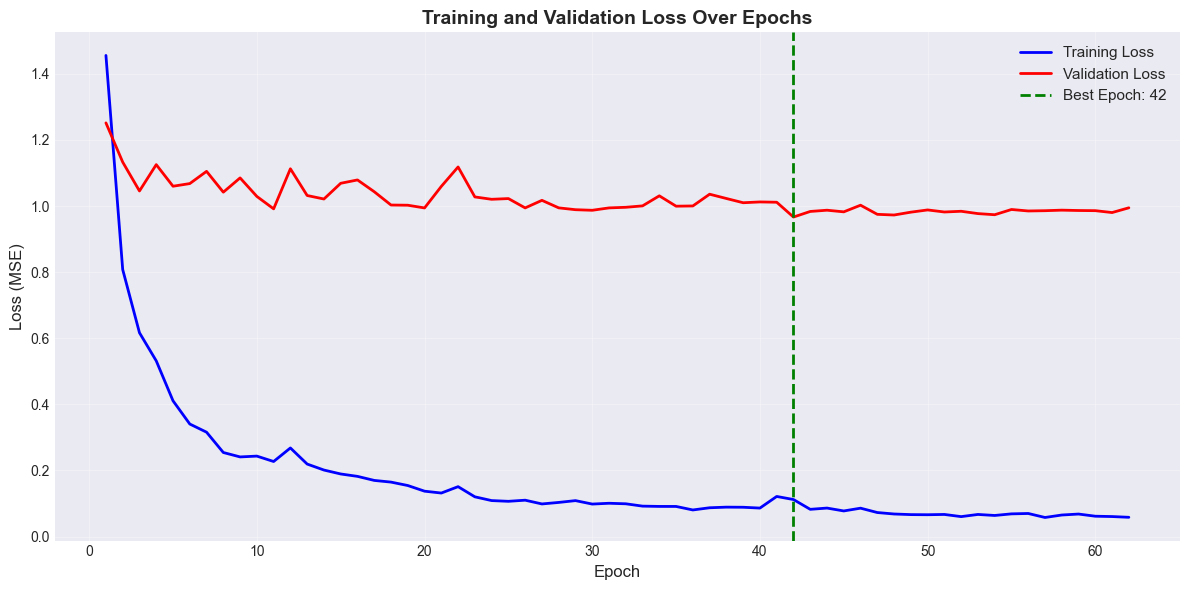

In [14]:
# Training curves
plt.figure(figsize=(12, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
best_epoch = np.argmin(val_losses) + 1
plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, 
            label=f'Best Epoch: {best_epoch}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

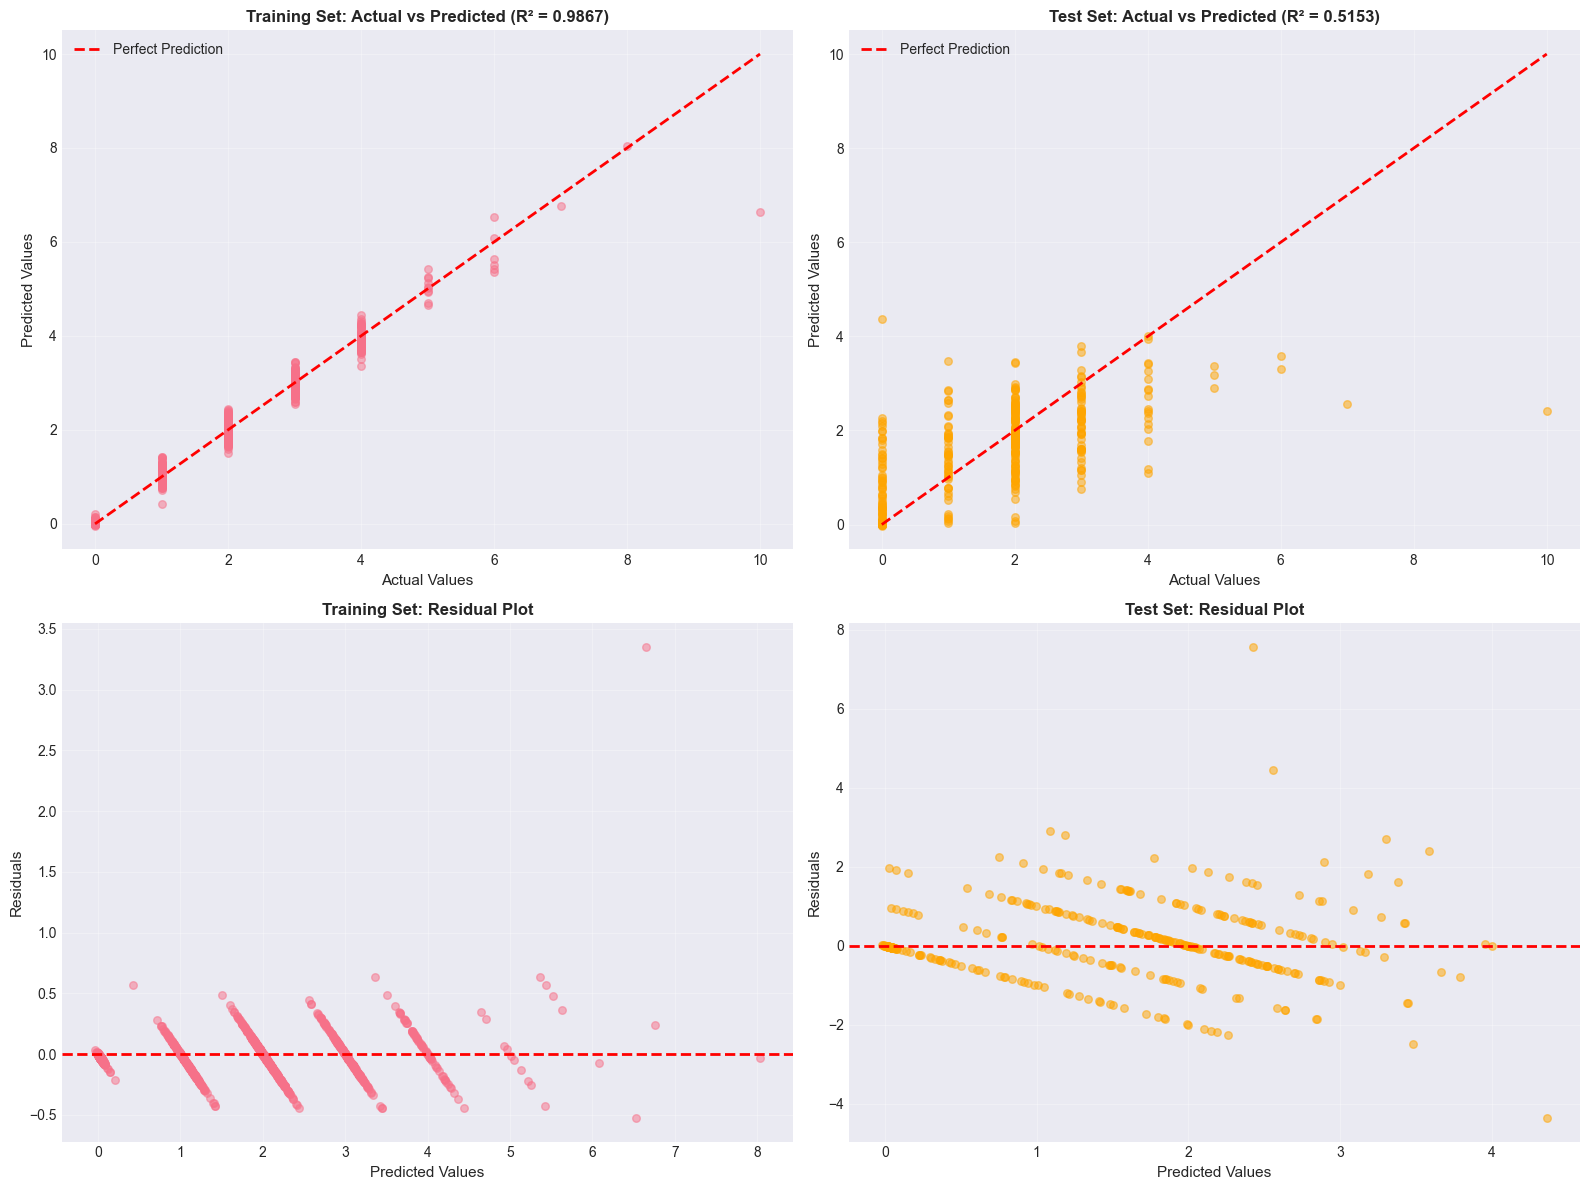

In [15]:
# Prediction visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, s=30)
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Values', fontsize=11)
axes[0, 0].set_ylabel('Predicted Values', fontsize=11)
axes[0, 0].set_title(f'Training Set: Actual vs Predicted (R² = {train_r2:.4f})', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Actual vs Predicted (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=30, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Values', fontsize=11)
axes[0, 1].set_ylabel('Predicted Values', fontsize=11)
axes[0, 1].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Residual plots
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.5, s=30)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Values', fontsize=11)
axes[1, 0].set_ylabel('Residuals', fontsize=11)
axes[1, 0].set_title('Training Set: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.5, s=30, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Values', fontsize=11)
axes[1, 1].set_ylabel('Residuals', fontsize=11)
axes[1, 1].set_title('Test Set: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Hyperparameter Sensitivity Analysis

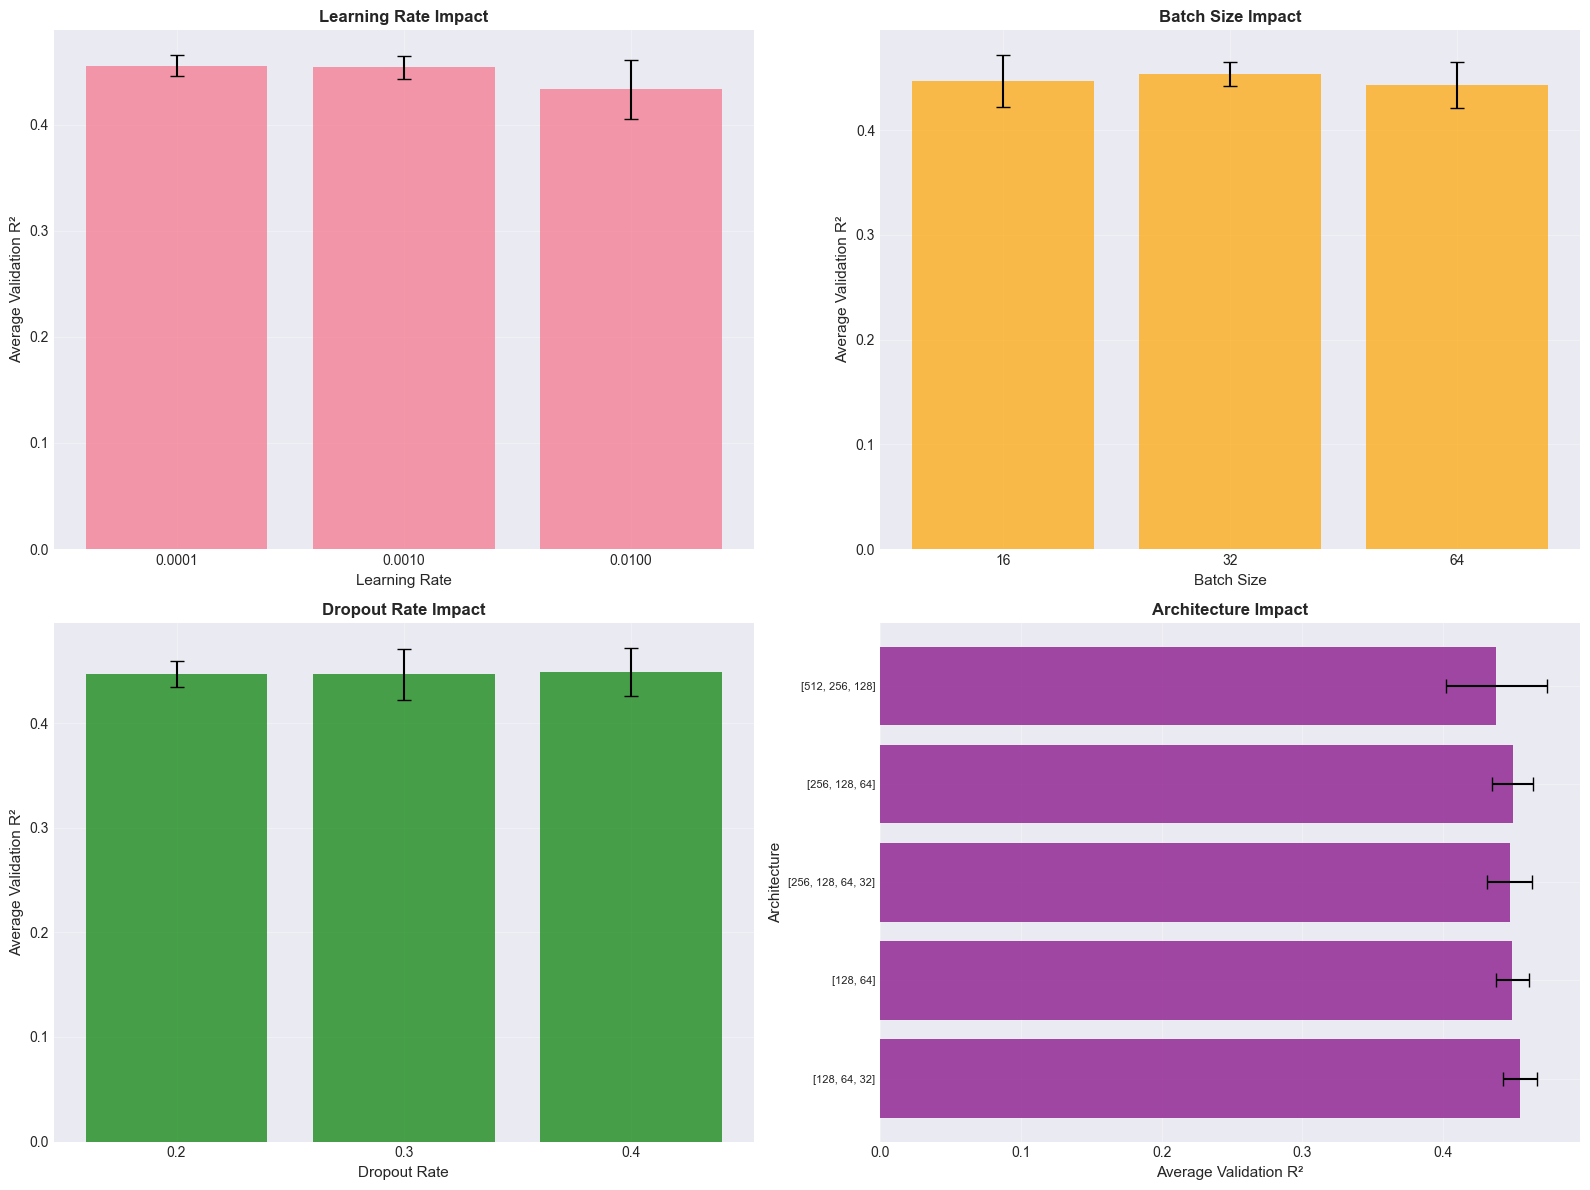

In [16]:
# Analyze impact of different hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract results for analysis
results_df = pd.DataFrame([
    {
        'hidden_dims_str': str(r['hidden_dims']),
        'dropout_rate': r['dropout_rate'],
        'learning_rate': r['learning_rate'],
        'batch_size': r['batch_size'],
        'avg_val_r2': r['avg_val_r2']
    }
    for r in tuning_results
])

# Learning rate impact
lr_grouped = results_df.groupby('learning_rate')['avg_val_r2'].agg(['mean', 'std'])
axes[0, 0].bar(range(len(lr_grouped)), lr_grouped['mean'], yerr=lr_grouped['std'], 
               capsize=5, alpha=0.7)
axes[0, 0].set_xticks(range(len(lr_grouped)))
axes[0, 0].set_xticklabels([f"{lr:.4f}" for lr in lr_grouped.index])
axes[0, 0].set_xlabel('Learning Rate', fontsize=11)
axes[0, 0].set_ylabel('Average Validation R²', fontsize=11)
axes[0, 0].set_title('Learning Rate Impact', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Batch size impact
bs_grouped = results_df.groupby('batch_size')['avg_val_r2'].agg(['mean', 'std'])
axes[0, 1].bar(range(len(bs_grouped)), bs_grouped['mean'], yerr=bs_grouped['std'], 
               capsize=5, alpha=0.7, color='orange')
axes[0, 1].set_xticks(range(len(bs_grouped)))
axes[0, 1].set_xticklabels(bs_grouped.index)
axes[0, 1].set_xlabel('Batch Size', fontsize=11)
axes[0, 1].set_ylabel('Average Validation R²', fontsize=11)
axes[0, 1].set_title('Batch Size Impact', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Dropout rate impact
dr_grouped = results_df.groupby('dropout_rate')['avg_val_r2'].agg(['mean', 'std'])
axes[1, 0].bar(range(len(dr_grouped)), dr_grouped['mean'], yerr=dr_grouped['std'], 
               capsize=5, alpha=0.7, color='green')
axes[1, 0].set_xticks(range(len(dr_grouped)))
axes[1, 0].set_xticklabels(dr_grouped.index)
axes[1, 0].set_xlabel('Dropout Rate', fontsize=11)
axes[1, 0].set_ylabel('Average Validation R²', fontsize=11)
axes[1, 0].set_title('Dropout Rate Impact', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Architecture impact
arch_grouped = results_df.groupby('hidden_dims_str')['avg_val_r2'].agg(['mean', 'std'])
axes[1, 1].barh(range(len(arch_grouped)), arch_grouped['mean'], xerr=arch_grouped['std'], 
                capsize=5, alpha=0.7, color='purple')
axes[1, 1].set_yticks(range(len(arch_grouped)))
axes[1, 1].set_yticklabels(arch_grouped.index, fontsize=8)
axes[1, 1].set_xlabel('Average Validation R²', fontsize=11)
axes[1, 1].set_ylabel('Architecture', fontsize=11)
axes[1, 1].set_title('Architecture Impact', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. LLM Agent Analysis

In [17]:
def analyze_results_with_llm(tuning_results, best_config, final_metrics, top_10_df):
    """
    Use LLM to provide comprehensive analysis of the neural network results.
    """
    
    if client is None:
        print("⚠️ LLM client not available. Skipping LLM analysis.")
        return None
    
    # Prepare data for LLM
    tuning_summary = {
        'total_configurations_tested': len(tuning_results),
        'best_configuration': {
            'hidden_dims': best_config['hidden_dims'],
            'dropout_rate': best_config['dropout_rate'],
            'learning_rate': best_config['learning_rate'],
            'batch_size': best_config['batch_size'],
            'avg_val_r2': best_config['avg_val_r2'],
            'std_val_r2': best_config['std_val_r2']
        },
        'top_10_configs': top_10_df.to_dict('records')
    }
    
    prompt = f"""
You are an expert data scientist analyzing neural network results for predicting the number of children (Q274) from World Values Survey data.

## TASK CONTEXT
A comprehensive hyperparameter tuning was performed using 5-fold cross-validation on a neural network model. The target variable is Q274 (number of children), and the model uses gradient descent optimization (Adam optimizer) to learn patterns from 286 survey features.

## HYPERPARAMETER TUNING RESULTS
{json.dumps(tuning_summary, indent=2)}

## FINAL MODEL PERFORMANCE (on held-out test set)
{json.dumps(final_metrics, indent=2)}

## ANALYSIS REQUIRED

Please provide a comprehensive analysis covering:

### 1. HYPERPARAMETER TUNING INSIGHTS
- What does the best configuration tell us about the optimal model architecture?
- Analyze the top 10 configurations - what patterns emerge?
- Which hyperparameters had the most significant impact on performance?
- Are there any surprising findings in the hyperparameter search results?

### 2. MODEL PERFORMANCE EVALUATION
- Interpret the R² scores in practical terms - what does {final_metrics['test_r2']:.4f} mean for predicting number of children?
- Assess the generalization capability (compare training vs test metrics)
- Is there evidence of overfitting or underfitting?
- How does the MAE of {final_metrics['test_mae']:.4f} translate to real-world prediction accuracy?

### 3. ARCHITECTURE ANALYSIS
- Comment on the optimal network depth ({len(best_config['hidden_dims'])} hidden layers)
- Discuss the layer sizes: {best_config['hidden_dims']}
- What does the dropout rate of {best_config['dropout_rate']} suggest about regularization needs?

### 4. OPTIMIZATION ANALYSIS
- Learning rate of {best_config['learning_rate']} - fast or conservative?
- Batch size of {best_config['batch_size']} - implications for training dynamics
- How do these choices affect the gradient descent optimization?

### 5. PRACTICAL IMPLICATIONS
- What does this model's performance suggest about the predictability of having children from survey responses?
- Are there likely hidden factors not captured by the model?
- What are the limitations and potential biases?

### 6. RECOMMENDATIONS FOR IMPROVEMENT
- Suggest 3-5 concrete next steps to potentially improve performance
- Consider: feature engineering, ensemble methods, alternative architectures, data augmentation
- Prioritize recommendations by likely impact

### 7. CROSS-VALIDATION STABILITY
- The best model has a std of ±{best_config['std_val_r2']:.6f} across folds - is this stable?
- What does this variability tell us about model reliability?

Please be specific, reference actual numbers from the data, and provide actionable insights. Keep the tone analytical but accessible.
"""
    
    print("\n" + "="*80)
    print("🤖 LLM AGENT ANALYSIS")
    print("="*80)
    print("\nGenerating comprehensive analysis...")
    print("This may take a moment...\n")
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            max_tokens=4000
        )
        
        analysis = response.choices[0].message.content
        
        print("="*80)
        print(analysis)
        print("="*80)
        
        return analysis
        
    except Exception as e:
        print(f"⚠️ Error calling LLM: {e}")
        return None

# Run LLM analysis
llm_analysis = analyze_results_with_llm(tuning_results, best_config, final_metrics, top_10_df)

if llm_analysis:
    print("\n✓ LLM Analysis Complete!")


🤖 LLM AGENT ANALYSIS

Generating comprehensive analysis...
This may take a moment...

⚠️ Error calling LLM: Error code: 403 - {'error': {'message': 'Project `proj_ZZE2rOamrPJz1EJg02zMMq8E` does not have access to model `gpt-4o`', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


## 14. Display Complete Results Summary## 14. Save Results and Models

In [19]:
# Display all results directly in the notebook

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

# 1. Best Configuration
print("\n" + "="*80)
print("1. BEST HYPERPARAMETER CONFIGURATION")
print("="*80)
print(f"\nHidden Layers Architecture: {best_config['hidden_dims']}")
print(f"Dropout Rate: {best_config['dropout_rate']}")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Batch Size: {best_config['batch_size']}")
print(f"\nCross-Validation Performance:")
print(f"  Average Validation R²: {best_config['avg_val_r2']:.6f}")
print(f"  Std Validation R²: ±{best_config['std_val_r2']:.6f}")
print(f"  Average Validation RMSE: {best_config['avg_val_rmse']:.6f}")
print(f"  Average Validation MAE: {best_config['avg_val_mae']:.6f}")

# 2. Model Architecture Details
print("\n" + "="*80)
print("2. FINAL MODEL ARCHITECTURE")
print("="*80)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Training Epochs Completed: {len(train_losses)}")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"\nNetwork Architecture:")
print(final_model)

# 3. Final Model Performance
print("\n" + "="*80)
print("3. FINAL MODEL PERFORMANCE ON TEST SET")
print("="*80)
print(f"\nTraining Set:")
print(f"  MSE:   {final_metrics['train_mse']:.6f}")
print(f"  RMSE:  {final_metrics['train_rmse']:.6f}")
print(f"  MAE:   {final_metrics['train_mae']:.6f}")
print(f"  R²:    {final_metrics['train_r2']:.6f}")
print(f"\nTest Set:")
print(f"  MSE:   {final_metrics['test_mse']:.6f}")
print(f"  RMSE:  {final_metrics['test_rmse']:.6f}")
print(f"  MAE:   {final_metrics['test_mae']:.6f}")
print(f"  R²:    {final_metrics['test_r2']:.6f}")
print(f"\nGeneralization Gap:")
print(f"  Train R² - Test R²: {final_metrics['train_r2'] - final_metrics['test_r2']:.6f}")
if final_metrics['train_r2'] - final_metrics['test_r2'] > 0.1:
    print("  ⚠️ Warning: Potential overfitting detected")
elif final_metrics['train_r2'] - final_metrics['test_r2'] < -0.05:
    print("  ⚠️ Warning: Test performance exceeds training (unusual)")
else:
    print("  ✓ Good generalization")

# 4. Top 10 Hyperparameter Configurations
print("\n" + "="*80)
print("4. TOP 10 HYPERPARAMETER CONFIGURATIONS")
print("="*80)
print("\n" + top_10_df.to_string(index=False))

# 5. Sample Predictions
print("\n" + "="*80)
print("5. SAMPLE TEST PREDICTIONS (First 20 samples)")
print("="*80)
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Residual': y_test.values - y_test_pred,
    'Abs_Error': np.abs(y_test.values - y_test_pred)
})
print("\n" + predictions_df.head(20).to_string(index=True))
print(f"\n... and {len(predictions_df) - 20} more test samples")

# 6. Prediction Statistics
print("\n" + "="*80)
print("6. PREDICTION ERROR STATISTICS")
print("="*80)
print(f"\nTest Set Residuals:")
print(f"  Mean Error: {predictions_df['Residual'].mean():.6f}")
print(f"  Std Error:  {predictions_df['Residual'].std():.6f}")
print(f"  Min Error:  {predictions_df['Residual'].min():.6f}")
print(f"  Max Error:  {predictions_df['Residual'].max():.6f}")
print(f"  Median Abs Error: {predictions_df['Abs_Error'].median():.6f}")
print(f"\nPrediction Range:")
print(f"  Min Predicted: {y_test_pred.min():.2f}")
print(f"  Max Predicted: {y_test_pred.max():.2f}")
print(f"  Mean Predicted: {y_test_pred.mean():.2f}")
print(f"\nActual Range:")
print(f"  Min Actual: {y_test.min():.2f}")
print(f"  Max Actual: {y_test.max():.2f}")
print(f"  Mean Actual: {y_test.mean():.2f}")

# 7. Training History
print("\n" + "="*80)
print("7. TRAINING HISTORY SUMMARY")
print("="*80)
print(f"\nTotal Epochs: {len(train_losses)}")
print(f"Initial Training Loss: {train_losses[0]:.6f}")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Initial Validation Loss: {val_losses[0]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Best Validation Loss: {min(val_losses):.6f} (Epoch {np.argmin(val_losses) + 1})")
print(f"\nTraining Improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
print(f"Validation Improvement: {((val_losses[0] - min(val_losses)) / val_losses[0] * 100):.2f}%")

# 8. Hyperparameter Impact Summary
print("\n" + "="*80)
print("8. HYPERPARAMETER IMPACT ANALYSIS")
print("="*80)
results_df = pd.DataFrame([
    {
        'hidden_dims_str': str(r['hidden_dims']),
        'dropout_rate': r['dropout_rate'],
        'learning_rate': r['learning_rate'],
        'batch_size': r['batch_size'],
        'avg_val_r2': r['avg_val_r2']
    }
    for r in tuning_results
])
print("\nLearning Rate Impact:")
lr_impact = results_df.groupby('learning_rate')['avg_val_r2'].agg(['mean', 'std', 'min', 'max'])
print(lr_impact.to_string())
print("\nDropout Rate Impact:")
dr_impact = results_df.groupby('dropout_rate')['avg_val_r2'].agg(['mean', 'std', 'min', 'max'])
print(dr_impact.to_string())
print("\nBatch Size Impact:")
bs_impact = results_df.groupby('batch_size')['avg_val_r2'].agg(['mean', 'std', 'min', 'max'])
print(bs_impact.to_string())
print("\nArchitecture Impact:")
arch_impact = results_df.groupby('hidden_dims_str')['avg_val_r2'].agg(['mean', 'std', 'min', 'max'])
print(arch_impact.to_string())

# 9. Complete Model Summary
print("\n" + "="*80)
print("9. COMPLETE MODEL SUMMARY (JSON FORMAT)")
print("="*80)
summary_dict = {
    'Best Configuration': {
        'hidden_dims': best_config['hidden_dims'],
        'dropout_rate': best_config['dropout_rate'],
        'learning_rate': best_config['learning_rate'],
        'batch_size': best_config['batch_size'],
        'cv_avg_val_r2': best_config['avg_val_r2'],
        'cv_std_val_r2': best_config['std_val_r2']
    },
    'Final Test Metrics': final_metrics,
    'Model Details': {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'training_epochs': len(train_losses),
        'input_features': X_train.shape[1],
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0]
    },
    'Hyperparameter Search': {
        'total_configurations_tested': len(tuning_results),
        'cv_folds': 5,
        'total_models_trained': len(tuning_results) * 5
    }
}
print(json.dumps(summary_dict, indent=2, default=str))

# Final message
print("\n" + "="*80)
print("✓ ALL RESULTS DISPLAYED SUCCESSFULLY")
print("="*80)
print("\nNote: Results are shown directly in the notebook.")
print("To save results to files, you can manually export any section above.")


COMPREHENSIVE RESULTS SUMMARY

1. BEST HYPERPARAMETER CONFIGURATION

Hidden Layers Architecture: [512, 256, 128]
Dropout Rate: 0.3
Learning Rate: 0.001
Batch Size: 32

Cross-Validation Performance:
  Average Validation R²: 0.474569
  Std Validation R²: ±0.041674
  Average Validation RMSE: 0.962166
  Average Validation MAE: 0.633362

2. FINAL MODEL ARCHITECTURE

Total Parameters: 311,297
Trainable Parameters: 311,297
Training Epochs Completed: 62
Best Validation Loss: 0.966705

Network Architecture:
NeuralNetworkRegressor(
  (network): Sequential(
    (0): Linear(in_features=286, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)

3. FINAL MODEL PERFORMANCE O